In [ ]:
## feature_column  特征列 

* numeric_column 数值列，最常用。


* bucketized_column 分桶列，由数值列生成，可以由一个数值列出多个特征，one-hot编码。


* categorical_column_with_identity 分类标识列，one-hot编码，相当于分桶列每个桶为1个整数的情况。


* categorical_column_with_vocabulary_list 分类词汇列，one-hot编码，由list指定词典。


* categorical_column_with_vocabulary_file 分类词汇列，由文件file指定词典。


* categorical_column_with_hash_bucket 哈希列，整数或词典较大时采用。


* indicator_column 指标列，由Categorical Column生成，one-hot编码


* embedding_column 嵌入列，由Categorical Column生成，嵌入矢量分布参数需要学习。嵌入矢量维数建议取类别数量的 4 次方根。


* crossed_column 交叉列，可以由除categorical_column_with_hash_bucket的任意分类列构成。

In [3]:
import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import tensorflow as tf 
from tensorflow.keras import layers,models 

In [4]:
#打印日志
def printlog(info):
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n"+"=========="*8 + "%s"%nowtime)
    print(info+'...\n')

In [5]:
printlog("step1: prepare dataset...")


================================================================================2020-05-14 10:53:05
step1: prepare dataset......



In [6]:
printlog("step1: prepare dataset...")

dftrain_raw = pd.read_csv("/Users/jun_yu/Documents/yujun_repository/tensorflow_2.0_study/eat_tensorflow2/data/titanic/train.csv")
dftest_raw = pd.read_csv("/Users/jun_yu/Documents/yujun_repository/tensorflow_2.0_study/eat_tensorflow2/data/titanic/test.csv")

dfraw = pd.concat([dftrain_raw,dftest_raw])


================================================================================2020-05-14 10:53:07
step1: prepare dataset......



In [7]:
dftrain_raw.shape, dftest_raw.shape 

((712, 12), (179, 12))

In [8]:
dfraw.shape 

(891, 12)

In [9]:
dfraw['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [10]:
def prepare_dfdata(dfraw):
    dfdata = dfraw.copy()
    dfdata.columns = [x.lower() for x in dfdata.columns]
    dfdata = dfdata.rename(columns={'survived':'label'})
    
    dfdata = dfdata.drop(['passengerid','name'],axis = 1)
    for col,dtype in dict(dfdata.dtypes).items():
        # 判断是否包含缺失值
        if dfdata[col].hasnans:
            # 添加标识是否缺失列
            dfdata[col + '_nan'] = pd.isna(dfdata[col]).astype('int32')   ## 添加每列是否 缺失标记 
            # 填充, 缺失值填充, 字符串按''填充, 非字符串按均值填充  
            if dtype not in [np.object,np.str,np.unicode]:                ## 每列做缺失填充  
                dfdata[col].fillna(dfdata[col].mean(),inplace = True)
            else:
                dfdata[col].fillna('',inplace = True)
    return(dfdata)

In [12]:
for col,dtype in dict(dfraw.dtypes).items():
    print(col,dtype)

PassengerId int64
Survived int64
Pclass int64
Name object
Sex object
Age float64
SibSp int64
Parch int64
Ticket object
Fare float64
Cabin object
Embarked object


In [13]:
dfdata = prepare_dfdata(dfraw)

In [14]:
dftrain = dfdata.iloc[0:len(dftrain_raw),:]
dftest = dfdata.iloc[len(dftrain_raw):,:]

In [15]:
dftrain.shape, dftest.shape 

((712, 13), (179, 13))

In [16]:
dftest.head(5)

,label,pclass,sex,age,sibsp,parch,ticket,fare,cabin,embarked,age_nan,cabin_nan,embarked_nan
0,0,3,female,29.699118,8,2,CA. 2343,69.5500,,S,1,1,0
1,0,3,female,20.000000,0,0,315096,8.6625,,S,0,1,0
2,0,3,female,9.000000,3,2,347088,27.9000,,S,0,1,0
3,1,1,female,18.000000,1,0,PC 17757,227.5250,C62 C64,C,0,0,0
4,1,3,female,0.750000,2,1,2666,19.2583,,C,0,1,0


In [17]:
# 从 dataframe 导入数据 
def df_to_dataset(df, shuffle=True, batch_size=32):
    dfdata = df.copy()
    if 'label' not in dfdata.columns:
        ds = tf.data.Dataset.from_tensor_slices(dfdata.to_dict(orient = 'list'))
    else: 
        labels = dfdata.pop('label')
        ds = tf.data.Dataset.from_tensor_slices((dfdata.to_dict(orient = 'list'), labels))  
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dfdata))
    ds = ds.batch(batch_size)
    return ds

In [18]:
ds_train = df_to_dataset(dftrain)
ds_test = df_to_dataset(dftest)

In [19]:
printlog("step2: make feature columns...")

feature_columns = [] 

# 数值列
for col in ['age','fare','parch','sibsp'] + [c for c in dfdata.columns if c.endswith('_nan')]:
    feature_columns.append(tf.feature_column.numeric_column(col))


================================================================================2020-05-14 10:53:59
step2: make feature columns......



In [20]:
feature_columns

[NumericColumn(key='age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='fare', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='parch', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='sibsp', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='age_nan', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='cabin_nan', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='embarked_nan', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]

In [21]:
# 分桶列
age = tf.feature_column.numeric_column('age')
age_buckets = tf.feature_column.bucketized_column(age, boundaries=[18, 25, 30, 35, 40, 45, 50, 55, 60, 65])

feature_columns.append(age_buckets)

In [22]:
feature_columns

[NumericColumn(key='age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='fare', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='parch', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='sibsp', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='age_nan', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='cabin_nan', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='embarked_nan', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 BucketizedColumn(source_column=NumericColumn(key='age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(18, 25, 30, 35, 40, 45, 50, 55, 60, 65))]

In [23]:
# 类别列
# 注意：所有的Catogorical Column类型最终都要通过indicator_column转换成Dense Column类型才能传入模型！！
sex = tf.feature_column.indicator_column(
      tf.feature_column.categorical_column_with_vocabulary_list(
      key='sex',vocabulary_list=["male", "female"]))
feature_columns.append(sex)

pclass = tf.feature_column.indicator_column(    ## 竟然是类别的, 但是数值是 int的  
      tf.feature_column.categorical_column_with_vocabulary_list(
      key='pclass',vocabulary_list=[1,2,3]))
feature_columns.append(pclass)

ticket = tf.feature_column.indicator_column(     ## 类别无法枚举完时, 采用hash_bucket
     tf.feature_column.categorical_column_with_hash_bucket('ticket',3))
feature_columns.append(ticket)

embarked = tf.feature_column.indicator_column(
      tf.feature_column.categorical_column_with_vocabulary_list(
      key='embarked',vocabulary_list=['S','C','B']))
feature_columns.append(embarked)

In [24]:
feature_columns

[NumericColumn(key='age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='fare', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='parch', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='sibsp', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='age_nan', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='cabin_nan', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='embarked_nan', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 BucketizedColumn(source_column=NumericColumn(key='age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(18, 25, 30, 35, 40, 45, 50, 55, 60, 65)),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), 

In [25]:
# 嵌入列   
cabin = tf.feature_column.embedding_column(   ## embedding 列, 拼合维度为2 
    tf.feature_column.categorical_column_with_hash_bucket('cabin',32),2)
feature_columns.append(cabin)

In [26]:
feature_columns

[NumericColumn(key='age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='fare', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='parch', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='sibsp', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='age_nan', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='cabin_nan', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='embarked_nan', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 BucketizedColumn(source_column=NumericColumn(key='age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(18, 25, 30, 35, 40, 45, 50, 55, 60, 65)),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), 

In [27]:
# 交叉列
pclass_cate = tf.feature_column.categorical_column_with_vocabulary_list(
          key='pclass',vocabulary_list=[1,2,3])

crossed_feature = tf.feature_column.indicator_column(   ## age分桶列 交叉pclass类别列
    tf.feature_column.crossed_column([age_buckets, pclass_cate],hash_bucket_size=15))

In [28]:
feature_columns.append(crossed_feature)

In [29]:
feature_columns

[NumericColumn(key='age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='fare', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='parch', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='sibsp', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='age_nan', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='cabin_nan', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='embarked_nan', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 BucketizedColumn(source_column=NumericColumn(key='age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(18, 25, 30, 35, 40, 45, 50, 55, 60, 65)),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), 

In [30]:
printlog("step3: define model...")

tf.keras.backend.clear_session()
model = tf.keras.Sequential([
  layers.DenseFeatures(feature_columns), #将特征列放入到tf.keras.layers.DenseFeatures中!!!
  layers.Dense(64, activation='relu'),
  layers.Dense(64, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])


================================================================================2020-05-14 10:54:16
step3: define model......



In [38]:
printlog("step4: train model...")

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


================================================================================2020-05-14 10:56:02
step4: train model......



In [36]:
history = model.fit(ds_train,
          validation_data=ds_test,
          epochs=10,)

Epoch 1/10
23/23 [==============================] - 0s 12ms/step - loss: 0.4743 - accuracy: 0.7879 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
23/23 [==============================] - 0s 7ms/step - loss: 0.4655 - accuracy: 0.8034 - val_loss: 0.4552 - val_accuracy: 0.7765
Epoch 3/10
23/23 [==============================] - 0s 7ms/step - loss: 0.4627 - accuracy: 0.8020 - val_loss: 0.4784 - val_accuracy: 0.7598
Epoch 4/10
23/23 [==============================] - 0s 9ms/step - loss: 0.5127 - accuracy: 0.7739 - val_loss: 0.4849 - val_accuracy: 0.7598
Epoch 5/10
23/23 [==============================] - 0s 7ms/step - loss: 0.4608 - accuracy: 0.8034 - val_loss: 0.4392 - val_accuracy: 0.7821
Epoch 6/10
23/23 [==============================] - 0s 8ms/step - loss: 0.4435 - accuracy: 0.8188 - val_loss: 0.5171 - val_accuracy: 0.7821
Epoch 7/10
23/23 [==============================] - 0s 7ms/step - loss: 0.4379 - accuracy: 0.8160 - val_loss: 0.4428 - val_accuracy: 0.7989
Epoch 8/10


In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_features (DenseFeature multiple                  64        
_________________________________________________________________
dense (Dense)                multiple                  3008      
_________________________________________________________________
dense_1 (Dense)              multiple                  4160      
_________________________________________________________________
dense_2 (Dense)              multiple                  65        
Total params: 7,297
Trainable params: 7,297
Non-trainable params: 0
_________________________________________________________________


In [267]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


================================================================================2020-05-14 09:31:56
step5: eval model......

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_features (DenseFeature multiple                  64        
_________________________________________________________________
dense (Dense)                multiple                  3008      
_________________________________________________________________
dense_1 (Dense)              multiple                  4160      
_________________________________________________________________
dense_2 (Dense)              multiple                  65        
Total params: 7,297
Trainable params: 7,297
Non-trainable params: 0
_________________________________________________________________


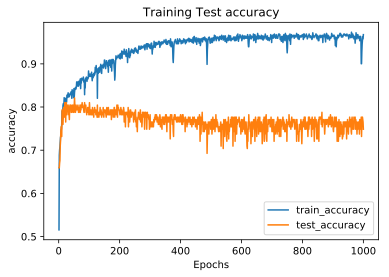

In [271]:
printlog("step5: eval model...")

model.summary()


%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
#              'bo-')
    plt.plot(epochs, val_metrics)
#              'ro-')
    
    plt.title('Training '+ 'Test '+metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'test_'+metric])
    plt.show()

plot_metric(history,"accuracy")